## step1. 設定需要的程式庫和參數

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

import numpy as np
import matplotlib.pyplot as plt

CTX_SIZE = 10
CODE_1_SIZE = 10
CODE_2_SIZE = 2
MAX_STEPS = 25000
BLUE_CENTER = (7, 7)
RED_CENTER = (-3, -3)

def gen_2d_guass_dist(mean, size=64):
    cov = [[0.5, 0.], [0., 0.5]]
    pts = np.random.multivariate_normal(mean, cov, size=size)
    return pts

def draw_data(blues, reds, title="Training Data"):
    plt.plot(BLUE_CENTER[0], BLUE_CENTER[1],
             "*", color="b", linewidth=1,
             markersize=12, label="blue center")
    plt.plot(RED_CENTER[0], RED_CENTER[1],
             "*", color="r", linewidth=1,
              markersize=12, label="red center")
    if blues is not None:
        plt.plot(blues[:, 0], blues[:, 1],
                 '.', alpha=0.12, color="b",
                 label="blue data")
    if reds is not None:
        plt.plot(reds[:, 0], reds[:, 1],
                 '.', alpha=0.12, color="r",
                 label="red data")
    plt.legend()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid()
    plt.show()

def draw_generated(dist, title="Generated Data"):
    plt.plot(BLUE_CENTER[0], BLUE_CENTER[1],
             "*", color="b", linewidth=1,
             markersize=12, label="blue center")
    plt.plot(RED_CENTER[0], RED_CENTER[1],
             "*", color="r", linewidth=1,
              markersize=12, label="red center")
    if dist is not None:
        plt.plot(dist[:, 0], dist[:, 1],
                 '.', alpha=0.8, color="orange",
                 label="generation")
    plt.legend()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid()
    plt.show()

## step2.建構 Generator 和 Discriminator

In [2]:
class FullyConnect(nn.Module):
    def __init__(self, in_size,
                       out_size,
                       activation=None):
        super().__init__()
        self.act = activation
        self.linear = nn.Linear(in_size, out_size)

    def forward(self, x):
        x = self.linear(x)
        if not self.act is None:
            x = self.act(x)
        return x

class FullyConnect(nn.Module):
    def __init__(self, in_size,
                       out_size,
                       activation=None):
        super().__init__()
        self.act = activation
        self.linear = nn.Linear(in_size, out_size)

    def forward(self, x):
        x = self.linear(x)
        if not self.act is None:
            x = self.act(x)
        return x

class Generator(nn.Module):
    def __init__(self, in_size=CTX_SIZE):
        super().__init__()
        self.model_dim = 128
        self.body = nn.Sequential(
            FullyConnect(in_size, self.model_dim, nn.ReLU(True)),
            FullyConnect(self.model_dim, self.model_dim, nn.ReLU(True)),
            FullyConnect(self.model_dim, self.model_dim, nn.ReLU(True))
        )
        self.head = nn.Sequential(
            FullyConnect(self.model_dim, 2)
        )

    def forward(self, x):
        x = self.body(x)
        x = self.head(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, use_sigmoid=True, weak_body=True):
        super().__init__()
        self.model_dim = 128
        if weak_body:
            self.body = nn.Sequential(
                FullyConnect(2, self.model_dim, nn.ReLU(True))
            )
        else:
            self.body = nn.Sequential(
                FullyConnect(2, self.model_dim, nn.ReLU(True)),
                FullyConnect(self.model_dim, self.model_dim, nn.ReLU(True)),
                FullyConnect(self.model_dim, self.model_dim, nn.ReLU(True))
            )
        self.head = nn.Sequential(
            FullyConnect(self.model_dim, 1)
        )
        self.head_q1 = nn.Sequential(
            FullyConnect(self.model_dim, CODE_1_SIZE)
        )
        self.head_q2 = nn.Sequential(
            FullyConnect(self.model_dim, CODE_2_SIZE)
        )
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        x = self.body(x)
        x = self.head(x)
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        return x

    def forward_with_q(self, x):
        mid = self.body(x)
        o = self.head(mid)
        if self.use_sigmoid:
            o = torch.sigmoid(o)
        q1 = torch.tanh(self.head_q1(mid))
        q2 = self.head_q2(mid)
        return o, q1, q2

    @torch.no_grad()
    def clip(self, bound=0.01):
        for param in self.parameters():
            param.data.clamp_(-bound, bound)

class LossTracer:
    def __init__(self, buf_size=500):
        self.buf_size = buf_size
        self.d_loss_buf = list()
        self.g_loss_buf = list()

    def add_d_loss(self, loss):
        self.d_loss_buf.append(loss)
        while len(self.d_loss_buf) > self.buf_size:
            self.d_loss_buf.pop(0)

    def add_g_loss(self, loss):
        self.g_loss_buf.append(loss)
        while len(self.g_loss_buf) > self.buf_size:
            self.g_loss_buf.pop(0)

    def get_d_loss(self):
        return sum(self.d_loss_buf) / len(self.d_loss_buf)

    def get_g_loss(self):
        return sum(self.g_loss_buf) / len(self.g_loss_buf)

## step3. 訓練 GAN 網路並輸出訓練結果

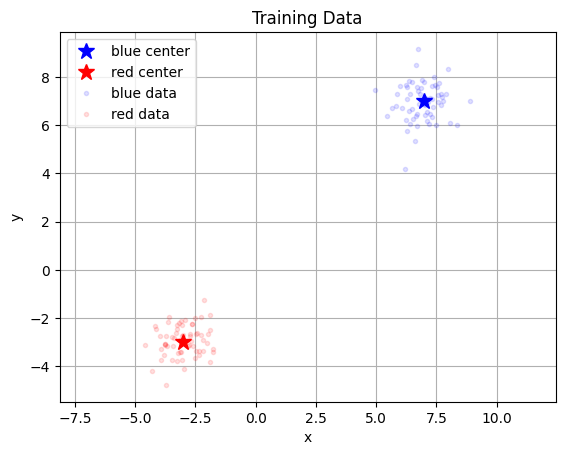

steps: 1000 -> G loss: 0.480239, D loss 1.10553
steps: 2000 -> G loss: 0.480197, D loss 1.10395
steps: 3000 -> G loss: 0.47987, D loss 1.10383
steps: 4000 -> G loss: 0.479217, D loss 1.10424
steps: 5000 -> G loss: 0.479959, D loss 1.10756


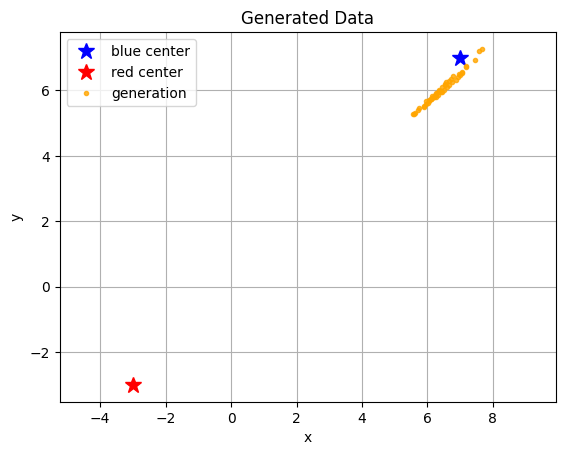

steps: 6000 -> G loss: 0.479138, D loss 1.10728
steps: 7000 -> G loss: 0.479361, D loss 1.10921
steps: 8000 -> G loss: 0.477831, D loss 1.11066
steps: 9000 -> G loss: 0.477879, D loss 1.10873
steps: 10000 -> G loss: 0.477879, D loss 1.11394


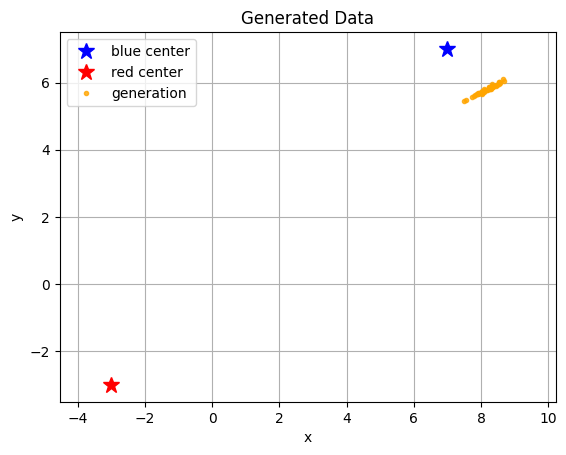

steps: 11000 -> G loss: 0.534113, D loss 1.02884
steps: 12000 -> G loss: 0.693579, D loss 0.700036
steps: 13000 -> G loss: 0.692285, D loss 0.702688
steps: 14000 -> G loss: 0.691501, D loss 0.701925
steps: 15000 -> G loss: 0.69361, D loss 0.698826


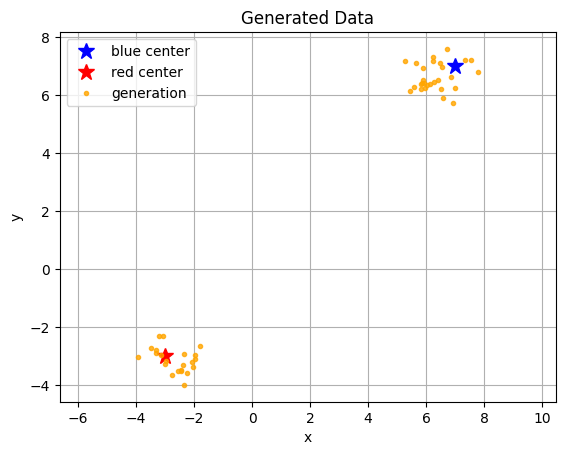

steps: 16000 -> G loss: 0.693062, D loss 0.700401
steps: 17000 -> G loss: 0.693771, D loss 0.697956
steps: 18000 -> G loss: 0.693042, D loss 0.700628
steps: 19000 -> G loss: 0.692411, D loss 0.699691
steps: 20000 -> G loss: 0.692889, D loss 0.699626


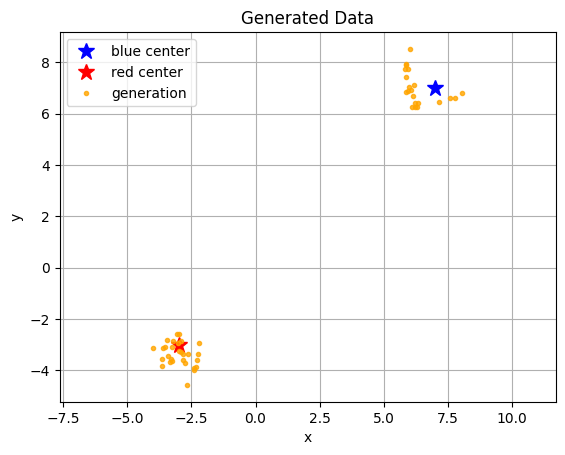

steps: 21000 -> G loss: 0.692894, D loss 0.698871
steps: 22000 -> G loss: 0.693146, D loss 0.699886
steps: 23000 -> G loss: 0.693317, D loss 0.698247
steps: 24000 -> G loss: 0.692989, D loss 0.698634
steps: 25000 -> G loss: 0.693377, D loss 0.699255


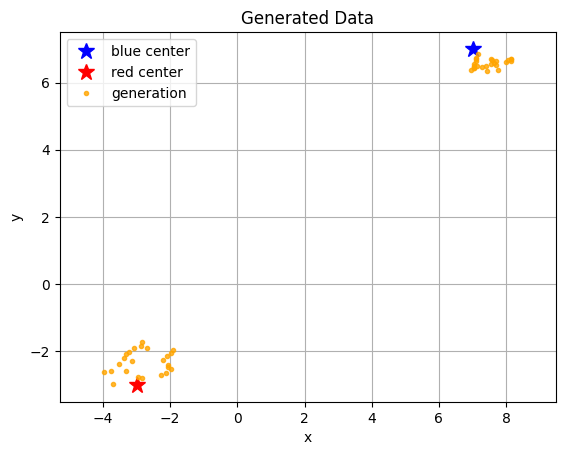

In [3]:
def train_gan():
    blues = gen_2d_guass_dist(BLUE_CENTER)
    reds = gen_2d_guass_dist(RED_CENTER)
    draw_data(blues, reds)
    pairs = np.concatenate((blues, reds), axis=0)

    generator = Generator()
    discriminator = Discriminator()
    loss_fn = nn.BCELoss()
    tracer = LossTracer()

    g_opt = optim.Adam(generator.parameters(),
                       lr=0.001,
                       betas=(0.5, 0.999),
                       weight_decay=0.)
    d_opt = optim.Adam(discriminator.parameters(),
                       lr=0.001,
                       betas=(0.5, 0.999),
                       weight_decay=0.)

    real_data = torch.from_numpy(np.array(pairs)).float()
    max_steps = MAX_STEPS
    batch_size = len(pairs)

    for s in range(max_steps):
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # train Discriminator
        d_opt.zero_grad()
        noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
        real_loss = loss_fn(discriminator(real_data), real_labels)
        fake_loss = loss_fn(discriminator(generator(noise).detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_opt.step()
        tracer.add_d_loss(d_loss.item())

        # train Generator
        g_opt.zero_grad()
        noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
        gen_data = generator(noise)
        g_loss = loss_fn(discriminator(gen_data), real_labels)
        g_loss.backward()
        g_opt.step()
        tracer.add_g_loss(g_loss.item())
        
        if (s+1) % 1000 == 0:
            print("steps: {} -> G loss: {:.6}, D loss {:.6}".format(
                      s+1, tracer.get_d_loss(), tracer.get_g_loss()))

        if (s+1) % 5000 == 0:
            noise = torch.normal(0, 1, size=(50, CTX_SIZE))
            generator.eval()
            with torch.no_grad():
                draw_generated(generator(noise).detach().cpu().numpy())
            generator.train()
            
train_gan()

## step4. 訓練 WGAN 網路並輸出訓練結果

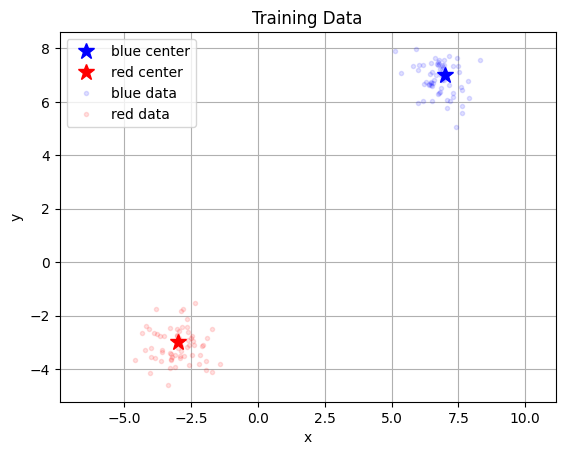

steps: 1000 -> G loss: -0.00612468, D loss -0.00374798
steps: 2000 -> G loss: -0.00190626, D loss -0.010485
steps: 3000 -> G loss: -0.00148392, D loss -0.0108073
steps: 4000 -> G loss: -0.000794056, D loss -0.0122401
steps: 5000 -> G loss: -0.000361204, D loss -0.0107772


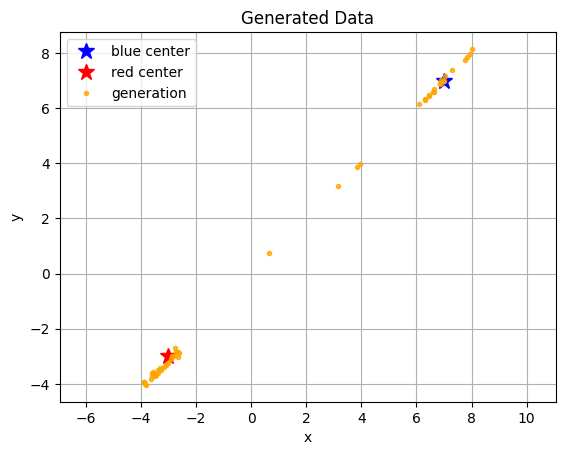

steps: 6000 -> G loss: -0.000168601, D loss -0.0100256
steps: 7000 -> G loss: -0.000136778, D loss -0.00965031
steps: 8000 -> G loss: -0.000119787, D loss -0.00962227
steps: 9000 -> G loss: -8.23782e-05, D loss -0.00836223
steps: 10000 -> G loss: -0.000124746, D loss -0.00850941


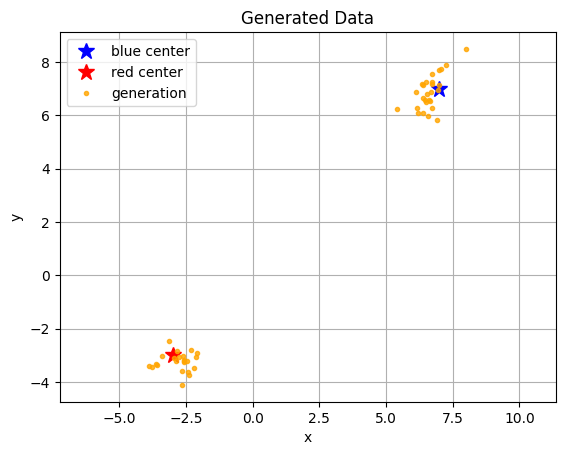

steps: 11000 -> G loss: -0.000127678, D loss -0.00913414
steps: 12000 -> G loss: -0.000108445, D loss -0.00962118
steps: 13000 -> G loss: -6.32423e-05, D loss -0.00936189
steps: 14000 -> G loss: -5.65875e-05, D loss -0.00926328
steps: 15000 -> G loss: -4.5174e-05, D loss -0.00931247


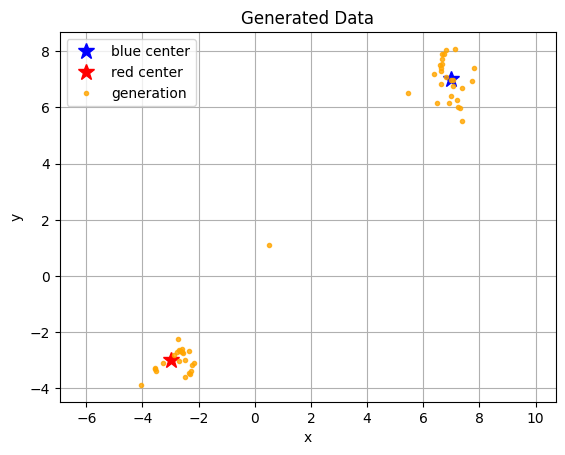

steps: 16000 -> G loss: -4.40416e-05, D loss -0.00927185
steps: 17000 -> G loss: -8.18283e-05, D loss -0.00912057
steps: 18000 -> G loss: -7.91511e-05, D loss -0.00970204
steps: 19000 -> G loss: -5.58745e-06, D loss -0.00913336
steps: 20000 -> G loss: -4.03937e-05, D loss -0.00934945


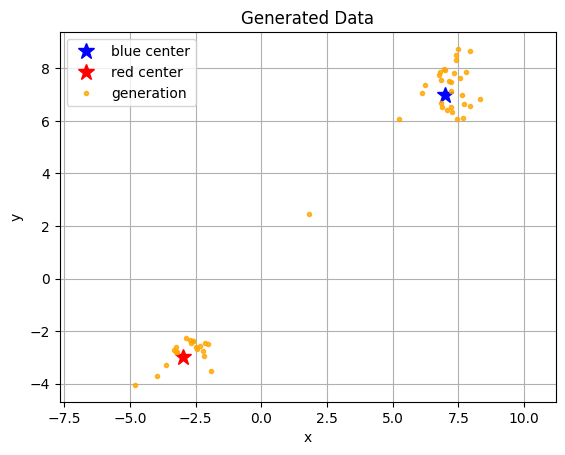

steps: 21000 -> G loss: 9.98322e-06, D loss -0.00925431
steps: 22000 -> G loss: -6.51127e-05, D loss -0.0093175
steps: 23000 -> G loss: -5.87143e-05, D loss -0.00971756
steps: 24000 -> G loss: -6.91423e-05, D loss -0.00945713
steps: 25000 -> G loss: -1.35557e-05, D loss -0.00902494


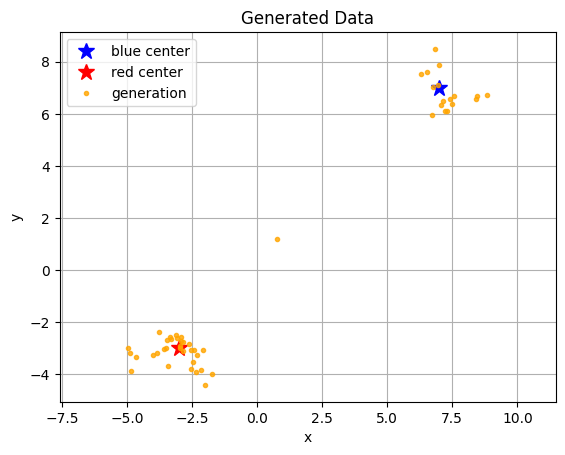

In [4]:
def train_wgan():
    blues = gen_2d_guass_dist(BLUE_CENTER)
    reds = gen_2d_guass_dist(RED_CENTER)
    draw_data(blues, reds)
    pairs = np.concatenate((blues, reds), axis=0)

    generator = Generator()
    discriminator = Discriminator(use_sigmoid=False, weak_body=False)
    discriminator.clip()

    g_opt = optim.RMSprop(generator.parameters(),
                          lr=0.00005,
                          weight_decay=0.)
    d_opt = optim.RMSprop(discriminator.parameters(),
                          lr=0.00005,
                          weight_decay=0.)

    real_data = torch.from_numpy(np.array(pairs)).float()
    max_steps = MAX_STEPS
    batch_size = len(pairs)
    tracer = LossTracer()

    for s in range(max_steps):
        # train Discriminator
        for _ in range(5):
            d_opt.zero_grad()
            noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
            pred_real_loss = discriminator(real_data)
            pred_real_loss = pred_real_loss.mean()
            pred_fake_loss = discriminator(generator(noise).detach())
            pred_fake_loss = pred_fake_loss.mean()
            d_loss = pred_fake_loss - pred_real_loss
            d_loss.backward()
            d_opt.step()
            discriminator.clip()
            tracer.add_d_loss(d_loss.item())
        
        # train Generator
        g_opt.zero_grad()
        noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
        gen_data = generator(noise)
        g_loss = discriminator(gen_data)
        g_loss = -g_loss.mean()
        g_loss.backward()
        g_opt.step()
        tracer.add_g_loss(g_loss.item())

        if (s+1) % 1000 == 0:
            print("steps: {} -> G loss: {:.6}, D loss {:.6}".format(
                      s+1, tracer.get_d_loss(), tracer.get_g_loss()))

        if (s+1) % 5000 == 0:
            noise = torch.normal(0, 1, size=(50, CTX_SIZE))
            generator.eval()
            with torch.no_grad():
                draw_generated(generator(noise).detach().cpu().numpy())
            generator.train()

train_wgan()

## step5. 訓練 WGAN-GP 網路並輸出訓練結果

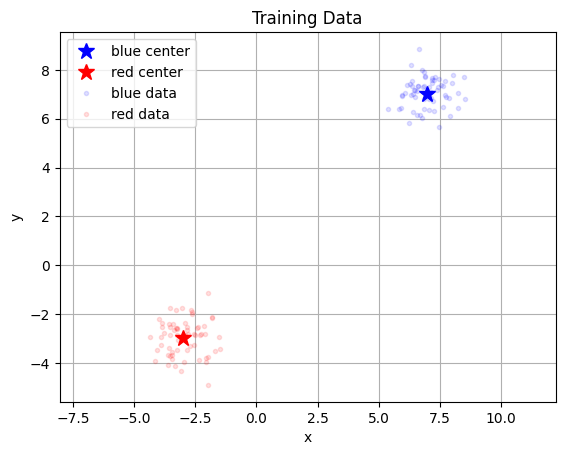

steps: 1000 -> G loss: -2.84097, D loss 6.76534
steps: 2000 -> G loss: -5.24743, D loss 51.3519
steps: 3000 -> G loss: -3.65949, D loss 39.112
steps: 4000 -> G loss: -1.90179, D loss 27.244
steps: 5000 -> G loss: -1.33776, D loss 23.4396


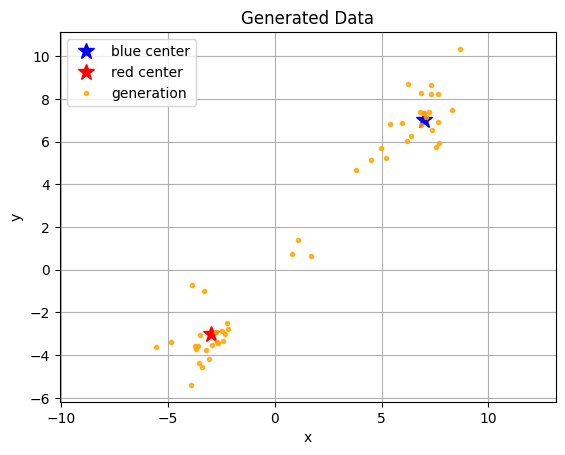

steps: 6000 -> G loss: -0.990138, D loss 21.1044
steps: 7000 -> G loss: -0.673346, D loss 17.8741
steps: 8000 -> G loss: -0.467741, D loss 20.0546
steps: 9000 -> G loss: -0.327913, D loss 22.7903
steps: 10000 -> G loss: -0.266485, D loss 20.0337


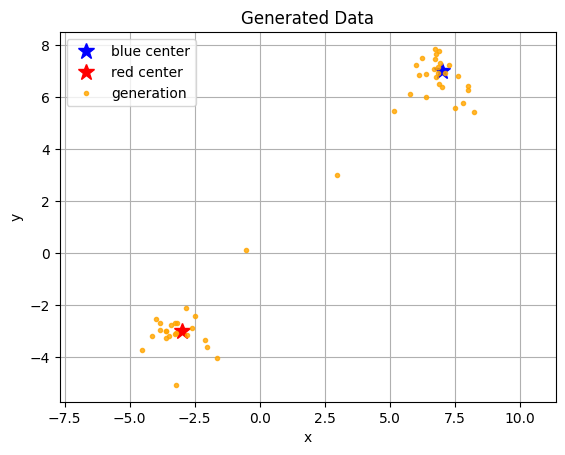

steps: 11000 -> G loss: -0.228877, D loss 19.4892
steps: 12000 -> G loss: -0.203752, D loss 20.8964
steps: 13000 -> G loss: -0.190895, D loss 20.6591
steps: 14000 -> G loss: -0.162738, D loss 20.2788
steps: 15000 -> G loss: -0.139943, D loss 19.6412


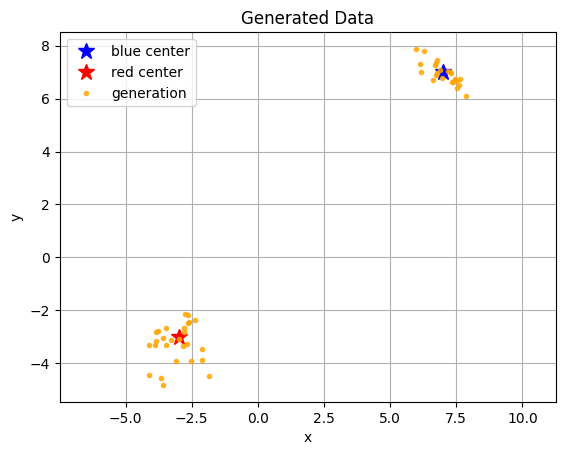

steps: 16000 -> G loss: -0.126269, D loss 18.6448
steps: 17000 -> G loss: -0.112167, D loss 17.4341
steps: 18000 -> G loss: -0.103434, D loss 16.3043
steps: 19000 -> G loss: -0.084521, D loss 14.7434
steps: 20000 -> G loss: -0.0736845, D loss 13.7383


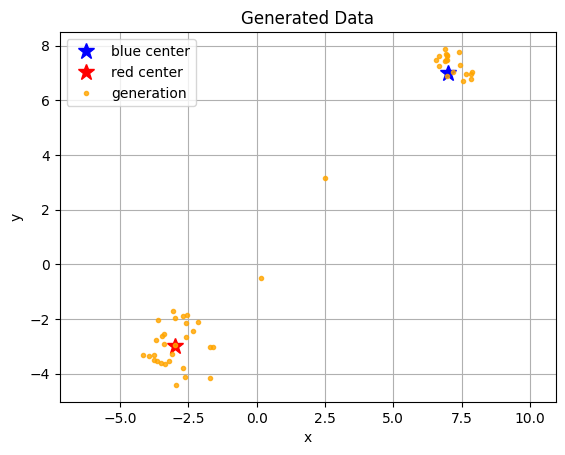

steps: 21000 -> G loss: -0.0661693, D loss 13.0196
steps: 22000 -> G loss: -0.0717736, D loss 12.3122
steps: 23000 -> G loss: -0.0712256, D loss 13.5687
steps: 24000 -> G loss: -0.0622646, D loss 12.6456
steps: 25000 -> G loss: -0.0515578, D loss 12.1399


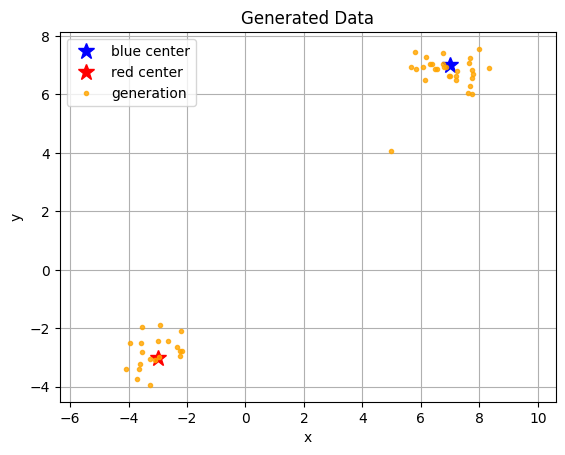

In [5]:
def compute_gradient_penalty(discriminator, real_data, generated_data):
    batch_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_data)
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)

    # Calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    gradient_penalty = ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

def train_wgan_gp():
    blues = gen_2d_guass_dist(BLUE_CENTER)
    reds = gen_2d_guass_dist(RED_CENTER)
    draw_data(blues, reds)
    pairs = np.concatenate((blues, reds), axis=0)

    generator = Generator()
    discriminator = Discriminator(use_sigmoid=False, weak_body=False)

    g_opt = optim.RMSprop(generator.parameters(),
                          lr=0.00005,
                          weight_decay=0.)
    d_opt = optim.RMSprop(discriminator.parameters(),
                          lr=0.00005,
                          weight_decay=0.)

    real_data = torch.from_numpy(np.array(pairs)).float()
    max_steps = MAX_STEPS
    batch_size = len(pairs)
    tracer = LossTracer()

    for s in range(max_steps):
        # train Discriminator
        for _ in range(5):
            d_opt.zero_grad()
            noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
            gen_data = generator(noise).detach()
            pred_real_loss = discriminator(real_data)
            pred_real_loss = pred_real_loss.mean()
            pred_fake_loss = discriminator(gen_data)
            pred_fake_loss = pred_fake_loss.mean()
            d_loss = pred_fake_loss - pred_real_loss + compute_gradient_penalty(discriminator, real_data, gen_data)
            d_loss.backward()
            d_opt.step()
            tracer.add_d_loss(d_loss.item())
        
        # train Generator
        g_opt.zero_grad()
        noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
        gen_data = generator(noise)
        g_loss = discriminator(gen_data)
        g_loss = -g_loss.mean()
        g_loss.backward()
        g_opt.step()
        tracer.add_g_loss(g_loss.item())

        if (s+1) % 1000 == 0:
            print("steps: {} -> G loss: {:.6}, D loss {:.6}".format(
                      s+1, tracer.get_d_loss(), tracer.get_g_loss()))

        if (s+1) % 5000 == 0:
            noise = torch.normal(0, 1, size=(50, CTX_SIZE))
            generator.eval()
            with torch.no_grad():
                draw_generated(generator(noise).detach().cpu().numpy())
            generator.train()

train_wgan_gp()

## step6. 訓練 info-GAN 網路並輸出訓練結果

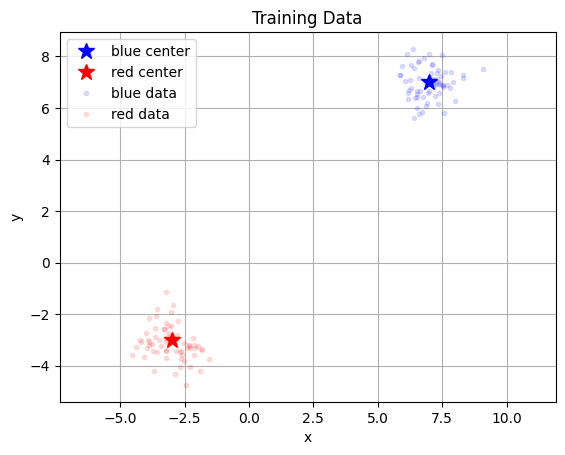

steps: 1000 -> G loss: 11.2247, D loss 11.3364
steps: 2000 -> G loss: 11.1685, D loss 11.2414
steps: 3000 -> G loss: 11.0998, D loss 11.1648
steps: 4000 -> G loss: 11.0419, D loss 11.0877
steps: 5000 -> G loss: 10.9954, D loss 11.0231


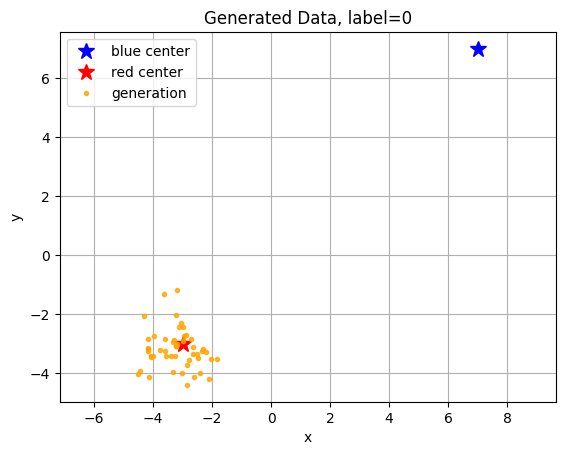

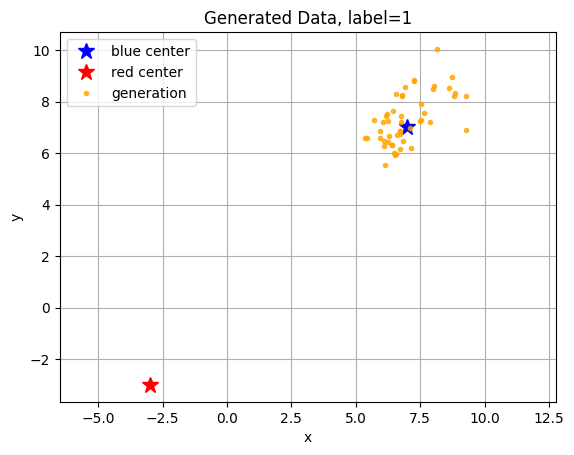

steps: 6000 -> G loss: 10.963, D loss 10.9851
steps: 7000 -> G loss: 10.9454, D loss 10.9695
steps: 8000 -> G loss: 10.9263, D loss 10.9564
steps: 9000 -> G loss: 10.9167, D loss 10.9628
steps: 10000 -> G loss: 10.9063, D loss 10.9812


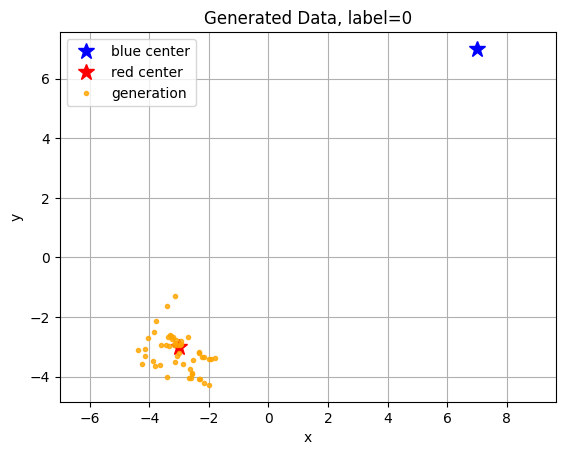

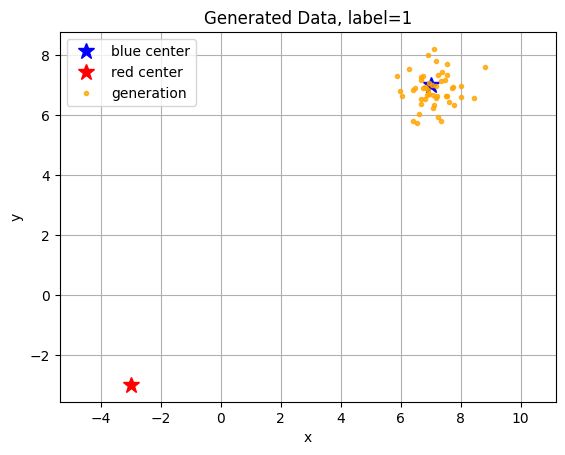

steps: 11000 -> G loss: 10.9022, D loss 11.0001
steps: 12000 -> G loss: 10.8888, D loss 11.017
steps: 13000 -> G loss: 10.8816, D loss 11.0428
steps: 14000 -> G loss: 10.8749, D loss 11.0725
steps: 15000 -> G loss: 10.8749, D loss 11.1094


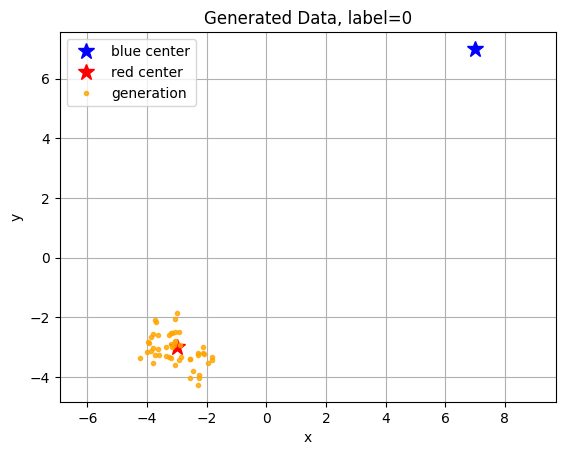

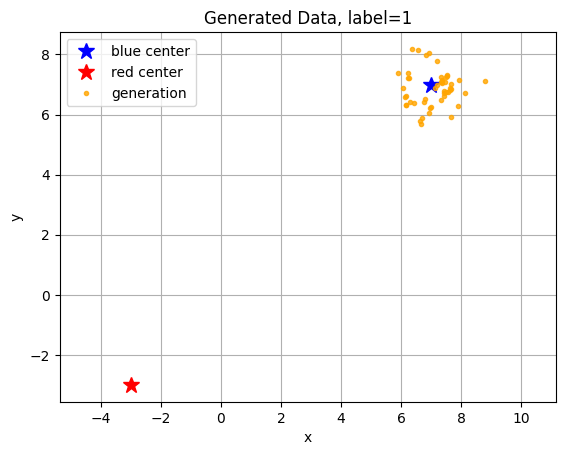

steps: 16000 -> G loss: 10.8638, D loss 11.1456
steps: 17000 -> G loss: 10.8647, D loss 11.1773
steps: 18000 -> G loss: 10.8634, D loss 11.2239
steps: 19000 -> G loss: 10.857, D loss 11.2513
steps: 20000 -> G loss: 10.8575, D loss 11.2898


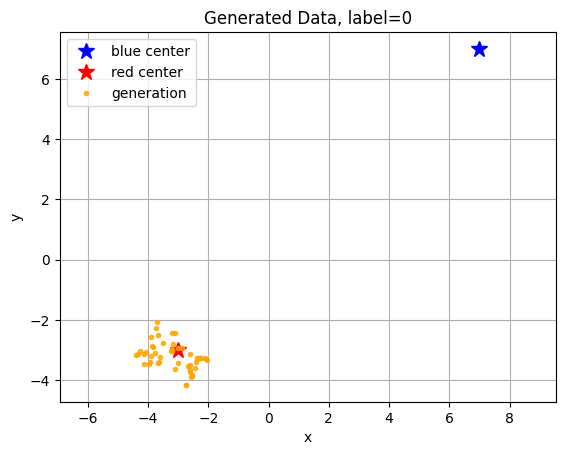

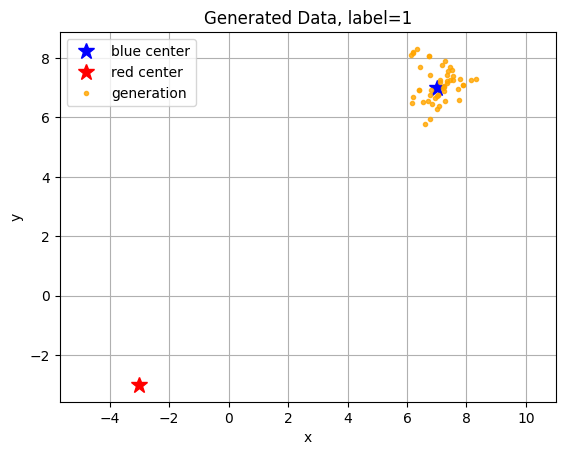

steps: 21000 -> G loss: 10.8461, D loss 11.3117
steps: 22000 -> G loss: 10.8451, D loss 11.3736
steps: 23000 -> G loss: 10.8374, D loss 11.4272
steps: 24000 -> G loss: 10.838, D loss 11.4924
steps: 25000 -> G loss: 10.8297, D loss 11.5325


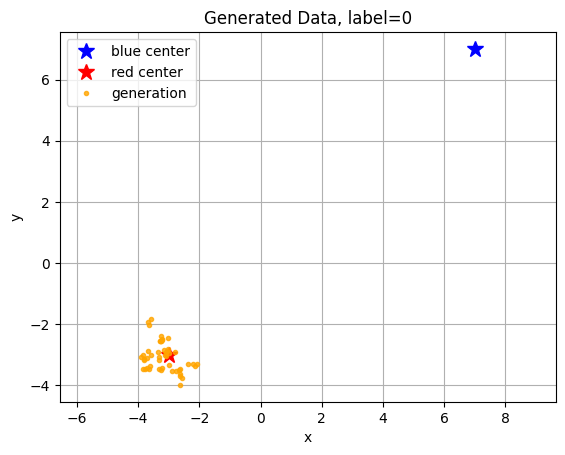

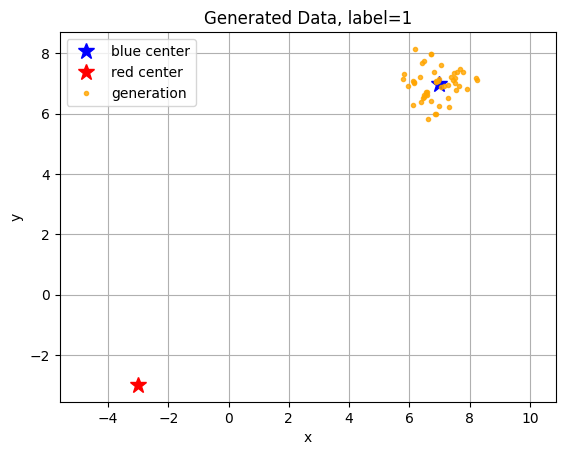

In [6]:
def train_info_gan():
    def gen_latent(batch_size, specific_label=None):
        noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
        code1 = 2 * torch.rand(size=(batch_size, CODE_1_SIZE)) - 1
        if specific_label is None:
            code2 = F.one_hot(torch.randint(0, CODE_2_SIZE, size=(batch_size,)), num_classes=CODE_2_SIZE)
        else:
            code2 = F.one_hot(torch.full((batch_size,), specific_label, dtype=torch.long), num_classes=CODE_2_SIZE)
        return torch.cat([noise, code1, code2], dim=1)
    
    def mutual_info_fn(pred_style, pred_label, latent):
        cross_entry = nn.CrossEntropyLoss()
        noise = latent[:, :CTX_SIZE]
        style = latent[:, CTX_SIZE:CTX_SIZE+CODE_1_SIZE]
        label = latent[:, CTX_SIZE+CODE_1_SIZE:]
        
        style_mean = pred_style
        style_std = torch.ones_like(pred_style) + 1e-6
        epsilon = (style - pred_style) / style_std
        loss_1 = torch.mean(torch.sum(
            - 0.5 * np.log(2 * np.pi) - torch.log(style_std) - 0.5 * torch.square(epsilon),
            dim=1
        ))
        loss_2 = cross_entry(pred_label, label)
        return loss_2 - loss_1

    blues = gen_2d_guass_dist(BLUE_CENTER)
    reds = gen_2d_guass_dist(RED_CENTER)
    draw_data(blues, reds)
    pairs = np.concatenate((blues, reds), axis=0)

    generator = Generator(CTX_SIZE + CODE_1_SIZE + CODE_2_SIZE)
    discriminator = Discriminator(weak_body=False)

    bce_loss_fn = nn.BCELoss()
    tracer = LossTracer()

    g_opt = optim.Adam(generator.parameters(),
                       lr=0.001,
                       betas=(0.5, 0.999),
                       weight_decay=0.)
    d_opt = optim.Adam(discriminator.parameters(),
                       lr=0.001,
                       betas=(0.5, 0.999),
                       weight_decay=0.)

    real_data = torch.from_numpy(np.array(pairs)).float()
    max_steps = MAX_STEPS
    batch_size = len(pairs)

    for s in range(max_steps):
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # train Discriminator
        d_opt.zero_grad()
        real_pred, _, _ = discriminator.forward_with_q(real_data)
        real_loss = bce_loss_fn(real_pred, real_labels)
        
        latent = gen_latent(batch_size)
        gen_data = generator(latent).detach()
        fake_pred, fake_pred_style, fake_pred_label = discriminator.forward_with_q(gen_data)
        fake_loss = bce_loss_fn(fake_pred, fake_labels)
        info_loss = mutual_info_fn(fake_pred_style, fake_pred_label, latent)

        d_loss = (real_loss + fake_loss) / 2 + info_loss
        d_loss.backward()
        d_opt.step()
        tracer.add_d_loss(d_loss.item())

        # train Generator
        g_opt.zero_grad()
        latent = gen_latent(batch_size)
        gen_data = generator(latent)
        fake_pred, fake_pred_style, fake_pred_label = discriminator.forward_with_q(gen_data)
        fake_loss = bce_loss_fn(fake_pred, real_labels)
        info_loss = mutual_info_fn(fake_pred_style, fake_pred_label, latent)

        g_loss = fake_loss + info_loss
        g_loss.backward()
        g_opt.step()
        tracer.add_g_loss(g_loss.item())
        
        if (s+1) % 1000 == 0:
            print("steps: {} -> G loss: {:.6}, D loss {:.6}".format(
                      s+1, tracer.get_d_loss(), tracer.get_g_loss()))

        if (s+1) % 5000 == 0:
            generator.eval()
            latent = gen_latent(50, 0)
            with torch.no_grad():
                draw_generated(generator(latent).detach().cpu().numpy(), title="Generated Data, label=0")
            latent = gen_latent(50, 1)
            with torch.no_grad():
                draw_generated(generator(latent).detach().cpu().numpy(), title="Generated Data, label=1")
            generator.train()
            
train_info_gan()